In [2]:
!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...


In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Configuration

In [2]:
CSV_FILE = './object-localization-dataset/train.csv'
DATA_DIR = './object-localization-dataset/'

DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001 #
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [3]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


In [57]:
df['label'].value_counts()

cucumber    63
eggplant    62
mushroom    61
Name: label, dtype: int64

In [70]:
(row.xmin,row.xmax)
(row.xmax, row.ymax)

(179, 202)

## Understand Dataset

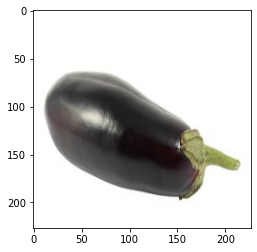

In [67]:
row = df.iloc[10]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

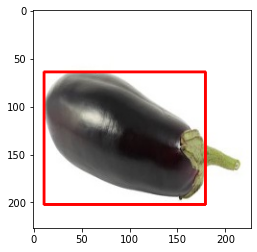

In [71]:
row = df.iloc[10]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pl1 = (row.xmin, row.ymin)
pl2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pl1,pl2,(255,0,0),2)

plt.imshow(bnd_box_img)

In [5]:
train_df, valid_df = train_test_split(df,test_size=0.2,random_state=42)

## Augmentations

In [6]:
import albumentations as A 

In [7]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip( p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate() #probability p = 0.5 default
], bbox_params=A.BboxParams(format= 'pascal_voc',label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip( p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format= 'pascal_voc', label_fields = ['class_labels']))

## Create Custom Dataset

In [8]:
class ObjLocDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, augmentations = None):
        self.df = df
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax
        
        bbox = [[xmin,ymin,xmax,ymax]]
        
        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
            img = data['image']
            bbox = data['bboxes'][0]
            
        img = torch.from_numpy(img).permute(2,0,1)/255.0 #(h,w,c) --> (c,h,w)
        bbox = torch.Tensor(bbox)
        
        return img,bbox

In [9]:
trainset = ObjLocDataset(train_df,train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [10]:
print(f'Total Examples in trainset {len(trainset)}')
print(f'Total Examples in validset {len(validset)}')

Total Examples in trainset 148
Total Examples in validset 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


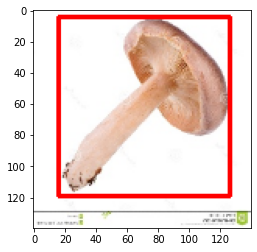

In [11]:
img,bbox = trainset[120]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin),int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_box_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1,pt2,(255,0,0),2)
plt.imshow(bnd_box_img)

## LOAD Dataset in batches

In [12]:
trainloader = torch.utils.data.DataLoader(trainset,BATCH_SIZE, shuffle=True) 
validloader = torch.utils.data.DataLoader(validset,BATCH_SIZE, shuffle=False) 

print(f'total no. batches in trainloader {len(trainloader)}')
print(f'total no. batches in validloader {len(validloader)}')

total no. batches in trainloader 10
total no. batches in validloader 3


In [21]:
for image, bbox in trainloader:
    break
    
print(f'shape of one batch images {image.shape}')
print(f'shape of one batch bbox {bbox.shape}')

shape of one batch images torch.Size([16, 3, 140, 140])
shape of one batch bbox torch.Size([16, 4])


## CREATE MODEL

In [23]:
from torch import nn
import timm

In [42]:
class ObjLocModel(nn.Module):
    
    def __init__(self):
        super(ObjLocModel, self).__init__()
        
        self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes = 4)
    
    def forward(self, images, gt_bboxes = None):
        bboxes = self.backbone(images)
        
        if gt_bboxes != None:
            loss = nn.MSELoss()(bboxes, gt_bboxes)
            return bboxes, loss
    
        return bboxes
    
model = ObjLocModel()
model.to(DEVICE);

In [46]:
#test
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img)

tensor([[ 1.6243,  1.8732, -2.6611,  1.1265]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## CREATE TRAIN AND EVAL FUNCTION

In [73]:
from tqdm import tqdm

In [75]:
len(trainloader)

10

In [47]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() #DROPOUT ON 
    
    for data in tqdm(dataloader):
        
        images, gt_bboxes = data
        images, gt_bboxes =images.to(DEVICE), gt_bboxes.to(DEVICE)
        
        bboxes, loss = model(images, gt_bboxes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [78]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval() #DROPout Off 
    
    with torch.no_grad():
            
        for data in tqdm(dataloader):

            images, gt_bboxes = data
            images, gt_bboxes =images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()

        return total_loss / len(dataloader)

## TRAINING LOOP 

In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [80]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print('WEIGHTS SAVED')
        best_valid_loss = valid_loss
        
    print(f'Epoch: {i + 1}, Train Loss : {train_loss}, Valid Loss : {valid_loss}')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.12it/s]


WEIGHTS SAVED
Epoch: 1, Train Loss : 2041.0144897460937, Valid Loss : 388.7235107421875


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.10it/s]


Epoch: 2, Train Loss : 1125.044207763672, Valid Loss : 681.6792602539062


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.35it/s]


WEIGHTS SAVED
Epoch: 3, Train Loss : 752.2690551757812, Valid Loss : 272.62969970703125


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 19.86it/s]


WEIGHTS SAVED
Epoch: 4, Train Loss : 511.3083221435547, Valid Loss : 175.84196980794272


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.97it/s]


WEIGHTS SAVED
Epoch: 5, Train Loss : 427.6407806396484, Valid Loss : 160.45630391438803


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 23.62it/s]


WEIGHTS SAVED
Epoch: 6, Train Loss : 266.11353912353513, Valid Loss : 160.13369750976562


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.42it/s]


Epoch: 7, Train Loss : 211.522509765625, Valid Loss : 210.0559539794922


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.27it/s]


Epoch: 8, Train Loss : 173.22108764648436, Valid Loss : 238.31675720214844


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.19it/s]


WEIGHTS SAVED
Epoch: 9, Train Loss : 162.6290252685547, Valid Loss : 131.05784606933594


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.79it/s]


Epoch: 10, Train Loss : 118.4821891784668, Valid Loss : 131.97565460205078


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.42it/s]


WEIGHTS SAVED
Epoch: 11, Train Loss : 112.38937301635742, Valid Loss : 118.60028839111328


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.29it/s]


WEIGHTS SAVED
Epoch: 12, Train Loss : 86.40477066040039, Valid Loss : 96.5638936360677


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.08it/s]


Epoch: 13, Train Loss : 94.23214569091797, Valid Loss : 98.14862060546875


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.86it/s]


Epoch: 14, Train Loss : 93.350825881958, Valid Loss : 138.1448974609375


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.27it/s]


WEIGHTS SAVED
Epoch: 15, Train Loss : 87.08510971069336, Valid Loss : 61.47418975830078


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.79it/s]


Epoch: 16, Train Loss : 90.38265342712403, Valid Loss : 78.44502385457356


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.19it/s]


Epoch: 17, Train Loss : 83.48845062255859, Valid Loss : 91.13020324707031


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.03it/s]


Epoch: 18, Train Loss : 79.27789993286133, Valid Loss : 97.82051849365234


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 23.87it/s]


Epoch: 19, Train Loss : 76.1959384918213, Valid Loss : 119.23203531901042


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.39it/s]


Epoch: 20, Train Loss : 74.80194282531738, Valid Loss : 95.3369649251302


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.38it/s]


WEIGHTS SAVED
Epoch: 21, Train Loss : 50.72020225524902, Valid Loss : 59.737561543782554


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.42it/s]


Epoch: 22, Train Loss : 51.617683792114256, Valid Loss : 72.01501719156902


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.54it/s]


Epoch: 23, Train Loss : 51.52217426300049, Valid Loss : 85.19226964314778


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.42it/s]


WEIGHTS SAVED
Epoch: 24, Train Loss : 57.365380859375, Valid Loss : 55.116294860839844


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.90it/s]


Epoch: 25, Train Loss : 54.82055320739746, Valid Loss : 63.98670450846354


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.99it/s]


Epoch: 26, Train Loss : 51.34669494628906, Valid Loss : 63.404534657796226


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.20it/s]


Epoch: 27, Train Loss : 46.76480407714844, Valid Loss : 67.96488825480144


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.58it/s]


Epoch: 28, Train Loss : 45.05944633483887, Valid Loss : 63.43053944905599


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 23.99it/s]


Epoch: 29, Train Loss : 50.473059844970706, Valid Loss : 63.663552602132164


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.08it/s]


Epoch: 30, Train Loss : 47.74992122650146, Valid Loss : 78.94308471679688


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.72it/s]


Epoch: 31, Train Loss : 57.19524879455567, Valid Loss : 59.907413482666016


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.20it/s]


Epoch: 32, Train Loss : 40.72172603607178, Valid Loss : 62.489888509114586


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 23.07it/s]


WEIGHTS SAVED
Epoch: 33, Train Loss : 73.97719993591309, Valid Loss : 48.063063303629555


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21.73it/s]


Epoch: 34, Train Loss : 45.70821590423584, Valid Loss : 81.36752319335938


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.58it/s]


Epoch: 35, Train Loss : 39.87369632720947, Valid Loss : 72.86679967244466


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 23.62it/s]


Epoch: 36, Train Loss : 43.971058464050294, Valid Loss : 60.44362131754557


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.02it/s]


Epoch: 37, Train Loss : 39.670856666564944, Valid Loss : 63.67057673136393


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.58it/s]


Epoch: 38, Train Loss : 42.39835186004639, Valid Loss : 66.55189005533855


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.25it/s]


Epoch: 39, Train Loss : 45.27283086776733, Valid Loss : 63.24618275960287


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.77it/s]

WEIGHTS SAVED
Epoch: 40, Train Loss : 53.85730247497558, Valid Loss : 44.815185546875


In [83]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


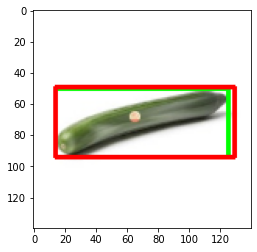

In [88]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    
    image, gt_boox = validset[30] #(c, h, w)
    #unsqueeze(0), It is used to add an extra dimension for batch as model takes (batch, channel, height, width)
    image = image.unsqueeze(0).to(DEVICE) #(bs, c,h,w) #
    out_bbox = model(image)
    
    utils.compare_plots(image, gt_boox, out_bbox)